<img src="https://ciat.cgiar.org/wp-content/uploads/Alliance_logo.png" alt="CIAT" id="logo" data-height-percentage="90" data-actual-width="140" data-actual-height="55">




#**Visualización y tratamiento de los datos de los sensores de caudal**


---





El siguiente codigo es para el tratamiento y visualización de los datos provenientes de los sensores de caudal. Estos sensores están ubicados en a los aforadores [UTAH ](https://studylib.es/doc/5067209/canaletas-portables-rbc-utah)  y están ubicados en la zona arrocera del norte de Perú. Estos sensores fueron implementados en esta zona para la medición de la cantidad de agua utilzada en el  bajo el proyecto ejecutado por la Alianza Bioversity y CIAT y Secretaria Técnica de CGIAR  (STC).


Este código es elaborado usando [Google Colab](https://www.adictosaltrabajo.com/2019/06/04/google-colab-python-y-machine-learning-en-la-nube/), entre sus principales caracterisiticas vale la pena destacar que es un entorno gratuito de Jupyter Notebook que no requiere configuración y que se ejecuta completamente en la nube. 

## **Requisitos de formato y organzación de los archivos**

El tipo de archivos para este procesamiento debe ser de tipo JSON ya que es el formato original de datos que proviene de los sensores. Si los archivos están guardados en otro tipo de extensión como TXT se debe cambiar a JSON, windows permite cambiar la [extensión](https://www.isumsoft.com/windows-10/change-file-extension-for-one-or-multiple-files.html#:~:text=Another%20way%20to%20open%20the,name) y los [nombres](https://www.isumsoft.com/windows-10/rename-multiple-files-at-once-in-windows-10.html) de múltiples archivos simultáneamente . Posteriormente, todos los archivos deben estar guardados en una sola carpeta.





## **Conexión a los datos y unión de los archivos JSON**

Para la lectura de datos se debe copiar la carpeta en [google drive](https://www.google.com/intl/es-419_ALL/drive/using-drive/) de la misma manera que Google coolab es un servicio gratuito de almacentamiento. Una vez guardados, se realiza la conexión con este notebook se ingresa en la parte izquierda (Files -> Amount Dive). O también puede crear la conexión mediante el siguiente comando, una vez autenticados se debe copiar la contraseña en el link habilitado. Para mayor información puede consultar en [[1]](https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/), [[2]](https://www.isumsoft.com/windows-10/rename-multiple-files-at-once-in-windows-10.html).


In [21]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Auntetificación para crear la conexión.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Ya creada la conexión, se debe seleccionar la carpeta de los datos, generalmente está ubicada en la carpeta *content/drive*, estos archivos están ubicados en el lado izquierdo de notebook.

In [23]:
import pandas as pd
import glob


def concatenearArchivos_Json (mypath):
 ''' Esta función recibe la dirección de la carpeta donde estan los archivos Json
     y devuelve un dataframe con la unión de todos los archivos.

     Parametros:
     mypath = La dirección donde están guardados los archivos Json
 '''
 all_files = glob.glob(mypath + "/*.json")

 lista = []

 for filename in all_files:
    df = pd.read_json(filename, lines=True)
    lista.append(df)
  #Concatenear todos los archivos JSON
 dfs = pd.concat(lista, axis=0, ignore_index = True)

  #Devuelve dataframe
 return dfs 


En la variable mypath debe colocar la ubicación del directorio de los archivos, haciendo click derecho sobre la carpeta obtiene la dirección. En este caso la dirección donde están los archivos es *'/content/drive/My Drive/Agua Peru/Agua'*.

In [24]:
mypath = '/content/drive/My Drive/Agua Peru/Agua'
datos_unidos = concatenearArchivos_Json (mypath = '/content/drive/My Drive/Agua Peru/Agua')



## **Transformación y descripción de las variables**

En este [documento](https://github.com/j-river1/Sensores_Caudal/blob/master/Descripcion_variables.md) está la descrición de las variables utilizadas en el proyecto y la respectivas transformaciones realizadas a los datos. Además de estas transformaciones es necesarios convertir el tiempo registrado del sensor,  de  [timestamp](https://www.programiz.com/python-programming/datetime/timestamp-datetime) a tiempo real.


In [25]:
from datetime import datetime


def transformacion (datos_unidos):
  '''
    Esta función transforma las variables para el calculo del caudal, volumen y 
    humedad del suelo.

    Esta función retorna un dataframe con las transformaciones
  '''

  #Convertir timestamp a tiempo real 
  datos_unidos['tiempo_real'] = datos_unidos['t']/1000
  datos_unidos['tiempo_real'] = datos_unidos['tiempo_real'].astype(int)
  datos_unidos['tiempo_real'] = datos_unidos['tiempo_real'].apply(datetime.fromtimestamp)

  #Caudal
  datos_unidos['caudal'] = 0.08693607*(abs(datos_unidos['h00']- datos_unidos['h01']))**(1.9322)

  #Volumen 
  datos_unidos['volumen'] = datos_unidos['caudal']*datos_unidos['f']*60/1000

  #Humedad del suelo 
  datos_unidos['gs00'] = datos_unidos['gs00'].astype(int)
  datos_unidos['humedad_suelo'] = 0 
  datos_unidos.loc[(datos_unidos['gs01'] <= 714)  | (datos_unidos['gs01'] > 480), 'humedad_suelo'] = 0.235*(datos_unidos['gs00'] - 480)
  datos_unidos.loc[datos_unidos['gs01'] < 480, 'humedad_suelo'] = 0

  #Retornar el data frame 
  return datos_unidos 

transformacion (datos_unidos).describe()


,ts,t,p00,pf00,tm00,hr00,bs00,dv00,vv00,gs00,gs01,h00,h01,ctSD,b,f,caudal,volumen,humedad_suelo
count,3.718000e+04,3.718000e+04,37180.0,37180.0,37180.0,37180.0,37180.000000,37180.000000,37180.0,37180.000000,37180.000000,37180.000000,37180.000000,37180.00000,37180.000000,37180.0,37180.000000,37180.000000,37180.000000
mean,1.557415e+12,1.557415e+12,0.0,0.0,0.0,0.0,601.749731,552.198516,0.0,601.567751,288.074960,51.648055,48.746904,704.18787,76.097095,10.0,5.688566,3.413139,1.176694
std,6.560667e+09,6.560667e+09,0.0,0.0,0.0,0.0,268.727216,189.104053,0.0,213.050641,195.606732,10.539123,12.151041,847.63583,12.505063,0.0,12.659447,7.595668,6.868728
min,1.546301e+12,1.546301e+12,0.0,0.0,0.0,0.0,9.000000,32.230000,0.0,25.000000,0.000000,0.000000,0.000000,0.00000,24.000000,10.0,0.000000,0.000000,-17.390000
25%,1.551722e+12,1.551722e+12,0.0,0.0,0.0,0.0,432.000000,433.400000,0.0,483.000000,117.000000,54.200000,53.200000,7.00000,67.000000,10.0,0.001016,0.000610,0.000000
50%,1.557033e+12,1.557033e+12,0.0,0.0,0.0,0.0,434.000000,447.480000,0.0,484.000000,246.000000,54.400000,54.100000,340.00000,79.000000,10.0,0.008490,0.005094,0.000000
75%,1.563219e+12,1.563219e+12,0.0,0.0,0.0,0.0,907.000000,743.080000,0.0,837.000000,485.000000,54.600000,54.400000,1186.00000,88.000000,10.0,0.086936,0.052162,0.705000
max,1.568712e+12,1.568712e+12,0.0,0.0,0.0,0.0,1167.000000,3593.520000,0.0,1022.000000,582.000000,59.500000,110.600000,3257.00000,90.000000,10.0,251.828382,151.097029,123.845000







## **Visualización de datos**

En esta sección se grafica los datos de caudal, volumen y humedad del suelo.


> **Volumen de Agua**





In [27]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datos = transformacion(datos_unidos)

def graficas_volumen (datos, clase = 1 ):
  '''
  Esta función es para graficar los datos. 
 
  Clase = Tipo de variable a graficar.
  1. Volumen
  2. Humedad del suelo
  3. Caudal 

  '''
  #index
  datos['tiempo_real'] = pd.to_datetime(datos['tiempo_real'])
  datos.index = datos['tiempo_real'] 

  #agruación por  mes 
  datos.groupby(datos['tiempo_real']).size()
  datos_graficasMensual = datos.resample('M').sum()
  datos_graficasDiaria = datos.resample('D').sum()


  if clase == 1:
    # Agrupacion de los datos
    datos.groupby(datos['tiempo_real']).size()
    datos_graficasMensual = datos.resample('M').sum()
    datos_graficasDiaria = datos.resample('D').sum()
    
    #Grafica de barras por mes
    plt.figure()
    plt.figure(figsize=(20,20))
    plt.subplot(211)
    datos_graficasMensual['volumen'].plot.bar(rot=0)
    plt.title("Volumen mensual de agua ", loc='center', fontsize=18, fontweight=0, color='black')
    #plt.xticks(rotation=90)
    plt.xlabel("Mes")
    plt.ylabel("Litros")


    #Grafica Mensual
    plt.subplot(212)
    plt.plot( 'volumen', data= datos_graficasDiaria, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=4)
    plt.title("Volumen diario de agua ", loc='center', fontsize=18, fontweight=0, color='black')
    plt.xlabel("Dia")
    plt.ylabel("Litros")

  if clase == 2:

    #agruación por  mes 
    datos.groupby(datos['tiempo_real']).size()
    datos_graficasMensual = datos.resample('M').mean()
    datos_graficasDiaria = datos.resample('D').mean()

    #Grafica de barras por mes
    plt.figure()
    plt.figure(figsize=(20,20))
    plt.subplot(211)
    plt.plot( 'caudal', data= datos_graficasMensual, marker='o', markerfacecolor='green', markersize=8, color='cyan', linewidth=4)
    plt.title("Caudal mensual de agua ", loc='center', fontsize=18, fontweight=0, color='black')
    #plt.xticks(rotation=90)
    plt.xlabel("Mes")
    plt.ylabel("Litros")


    #Grafica Mensual
    plt.subplot(212)
    plt.plot( 'volumen', data= datos_graficasDiaria, marker='o', markerfacecolor='green', markersize=8, color='cyan', linewidth=4)
    plt.title("Caudal promedio diario de agua ", loc='center', fontsize=18, fontweight=0, color='black')
    plt.xlabel("Dia")
    plt.ylabel("Litros")

  if clase == 3:

    #agruación por  mes 
    datos.groupby(datos['tiempo_real']).size()
    datos_graficasMensual = datos.resample('M').mean()
    datos_graficasDiaria = datos.resample('D').mean()

    #Grafica de barras por mes
    plt.figure()
    plt.figure(figsize=(20,20))
    plt.subplot(211)
    plt.plot( 'humedad_suelo', data= datos_graficasMensual, marker='o', markerfacecolor='tomato', markersize=8, color='lime', linewidth=4)
    plt.title("Humedad promedio mensual del agua", loc='center', fontsize=18, fontweight=0, color='black')
    #plt.xticks(rotation=90)
    plt.xlabel("Mes")
    plt.ylabel("Litros")


    #Grafica Mensual
    plt.subplot(212)
    plt.plot( 'humedad_suelo', data= datos_graficasDiaria, marker='o', markerfacecolor='tomato', markersize=8, color='lime', linewidth=4)
    plt.title("Humedad promedio diario de  agua", loc='center', fontsize=18, fontweight=0, color='black')
    plt.xlabel("Dia")
    plt.ylabel("Litros")



A contuniación se grafican el consumen mensual y diario registrados por lo sensores.

<Figure size 432x288 with 0 Axes>

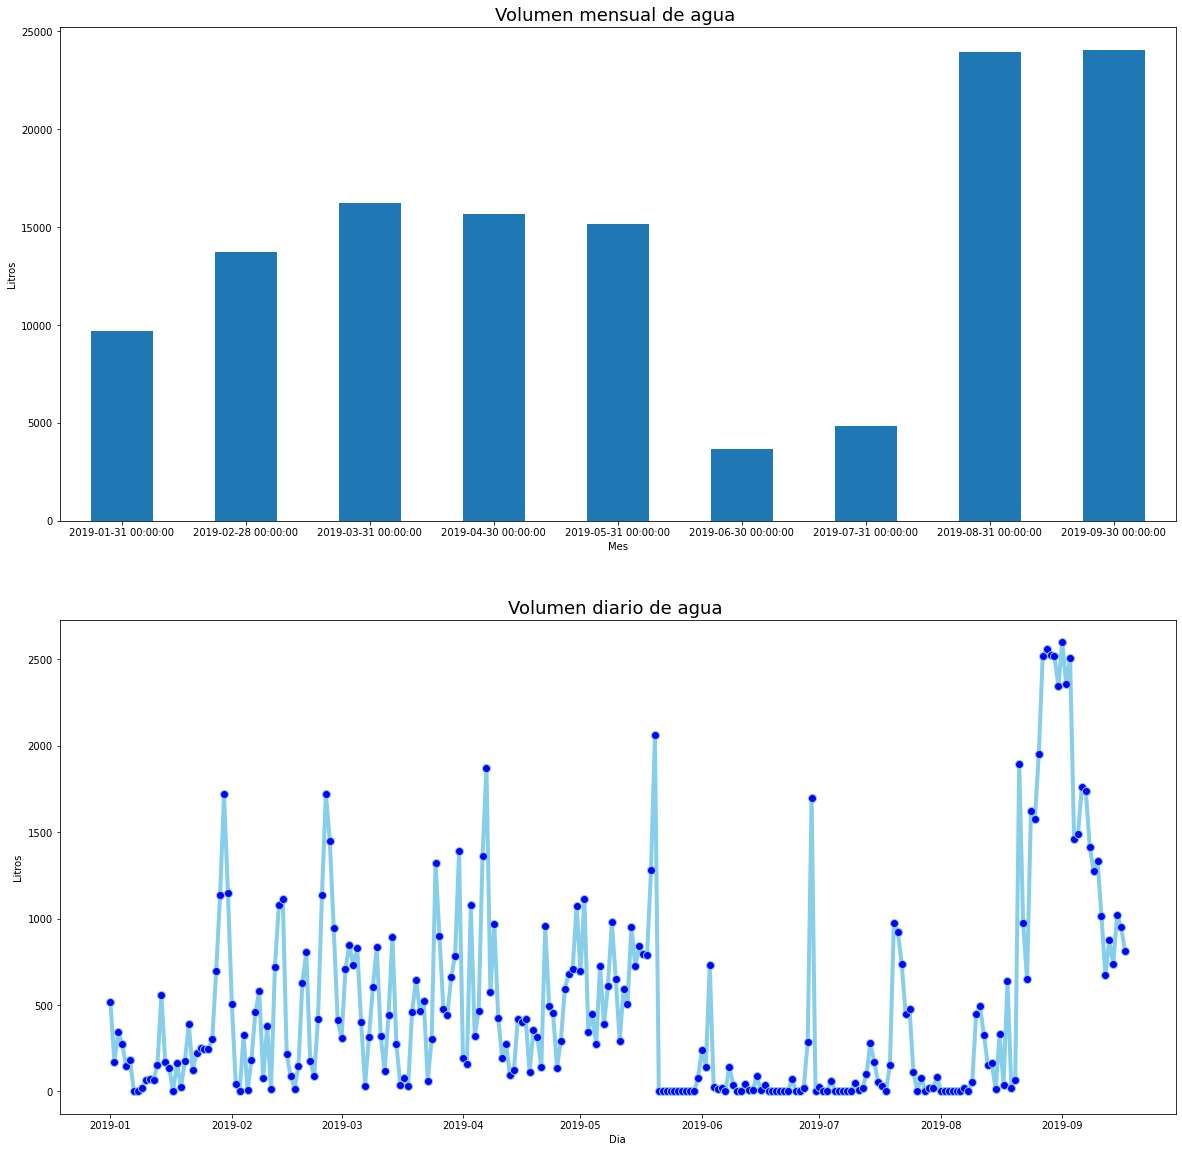

In [28]:
datos = transformacion(datos_unidos)
graficas_volumen(datos, clase= 1)

## **Caudal**

<Figure size 432x288 with 0 Axes>

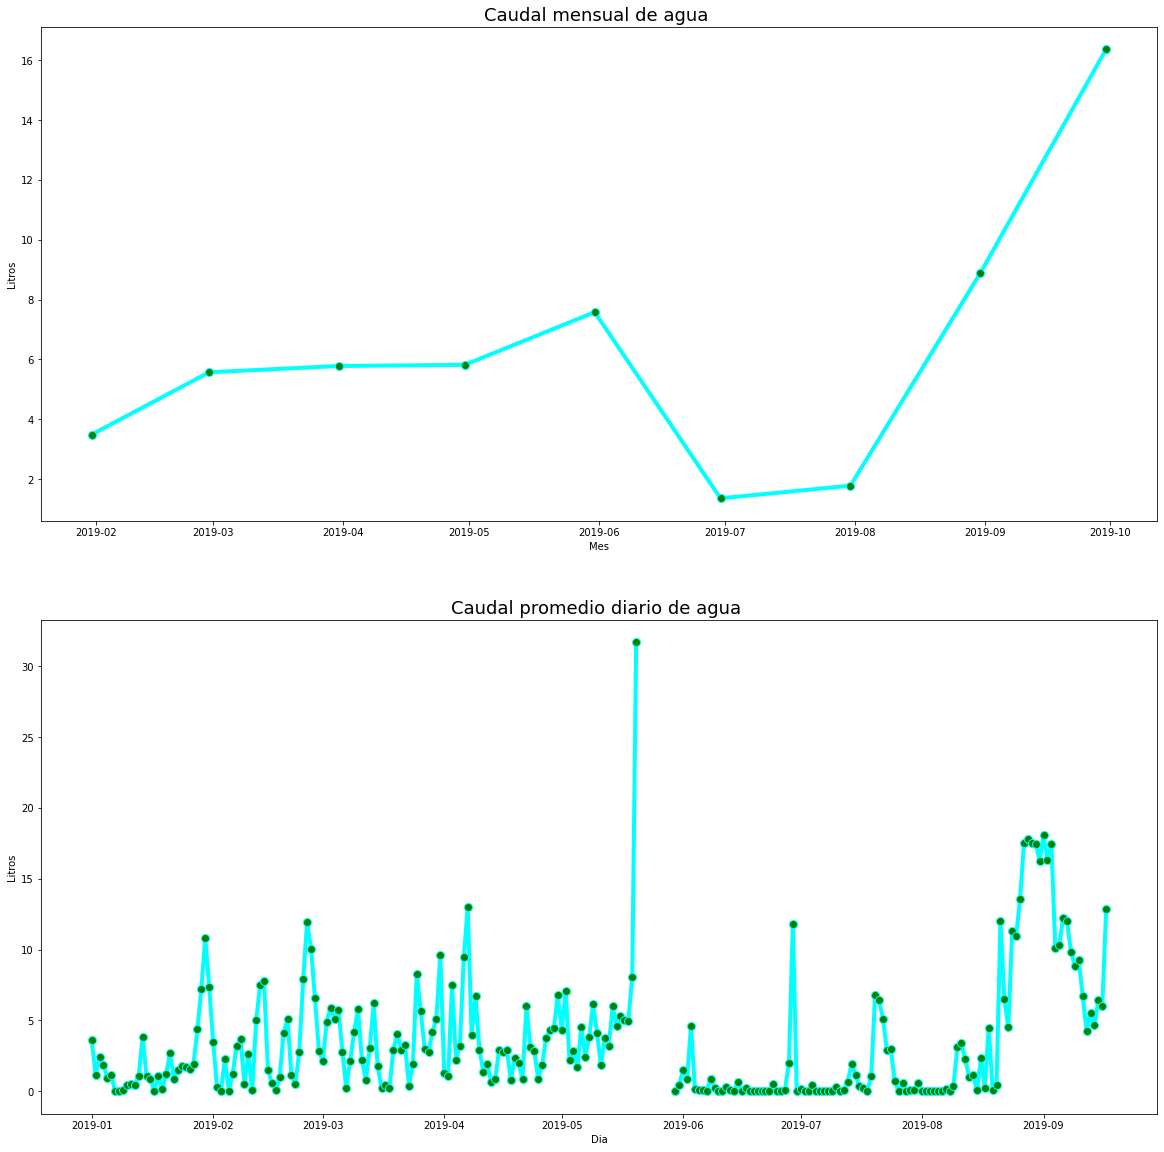

In [29]:
datos = transformacion(datos_unidos)
graficas_volumen(datos, clase= 2)

## **Humedad**

<Figure size 432x288 with 0 Axes>

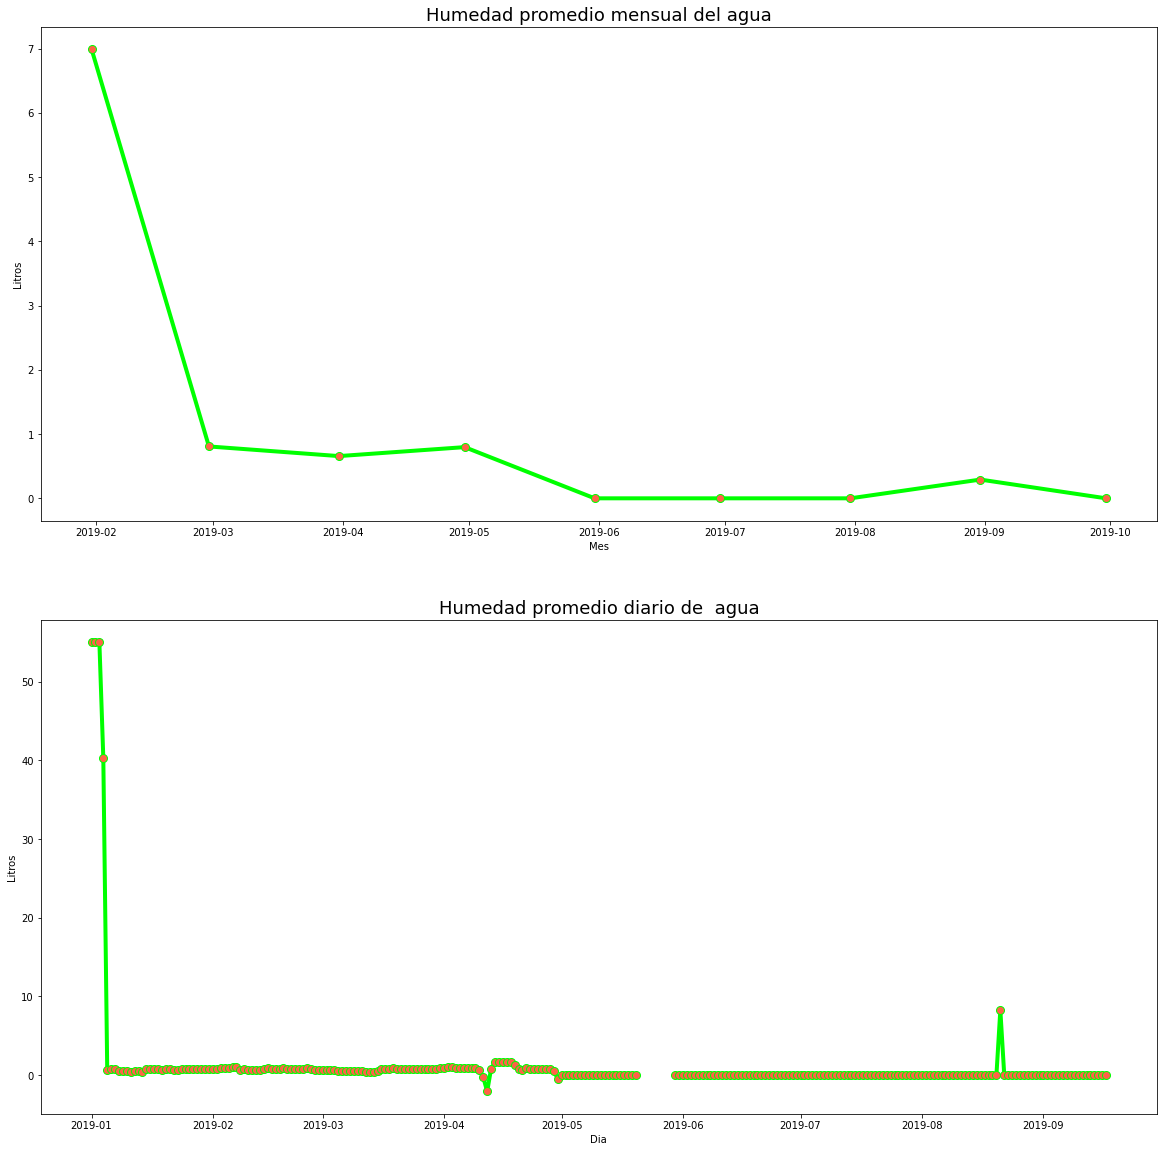

In [30]:
datos = transformacion(datos_unidos)
graficas_volumen(datos, clase= 3)

#Referencias 
[1]. https://www.isumsoft.com/windows-10/change-file-extension-for-one-or-multiple-files.html#:~:text=Another%20way%20to%20open%20the,name)%2C%20and%20press%20Enter.
[2] https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92